# 04 – Autoencoder Base Model (OOF + Test)  
This notebook trains a **PyTorch Autoencoder** anomaly detector on the scaled + one-hot encoded dataset produced by:

- `01_preprocessing_real_time_split.ipynb`

It produces:
- `oof_ae.csv` (out-of-fold reconstruction-error *risk scores* for the **train** period)
- `test_ae.csv` (risk scores for the **future test** period)

Key requirements implemented:
- Time-aware approach (no leakage):
  - OOF created with **TimeSeriesSplit** (each validation chunk is scored by a model trained only on the past)
- **Optuna** hyperparameter tuning to maximize **F2-score** at a fixed threshold
- Converts reconstruction error to a **0–1 risk score** via **MinMax scaling** (fit on train fold only)
- **Confusion matrix** + metrics on the **test** period (labels used only for evaluation)
- **SHAP** explanation of reconstruction-error risk score (Permutation/Kernel via `shap.Explainer`)

> Threshold is set to `0.05` by default (change once at the top and it updates everywhere).

In [1]:
# --- (Optional) Install dependencies (Colab-safe)
try:
    import optuna  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna"])

try:
    import shap  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])

try:
    import tqdm  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tqdm"])


In [13]:
import os, sys, json, random, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

warnings.filterwarnings("ignore")

# -----------------------------
# Global config (EDIT HERE)
# -----------------------------
SEED = 42
N_SPLITS_OOF = 5      # OOF folds (time-aware)
N_TRIALS = 2        # Optuna trials (AE training is heavier than trees)
THRESHOLD = 0.01

# Training defaults (Optuna will override some of these)
MAX_EPOCHS = 50
PATIENCE = 8

# Whether Optuna uses a single time-aware holdout (fast) or full CV (slow)
OPTUNA_USE_CV = False
HOLDOUT_FRAC = 0.20   # used when OPTUNA_USE_CV=False

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

# Detect Colab + mount Drive
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")

datapath = "/content/drive/MyDrive/RThesis/" if IN_COLAB else "./"
os.makedirs(datapath, exist_ok=True)

print("datapath =", datapath)


device = cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
datapath = /content/drive/MyDrive/RThesis/


In [3]:
# -----------------------------
# Load preprocessed scaled datasets
# -----------------------------
X_train_path = os.path.join(datapath, "X_train_scaled.csv")
X_test_path  = os.path.join(datapath, "X_test_scaled.csv")
y_train_path = os.path.join(datapath, "y_train.csv")
y_test_path  = os.path.join(datapath, "y_test.csv")
train_keys_path = os.path.join(datapath, "train_keys.csv")
test_keys_path  = os.path.join(datapath, "test_keys.csv")

for p in [X_train_path, X_test_path, y_train_path, y_test_path, train_keys_path, test_keys_path]:
    assert os.path.exists(p), f"Missing file: {p}"

X_train_df = pd.read_csv(X_train_path)
X_test_df  = pd.read_csv(X_test_path)

y_train = pd.read_csv(y_train_path)["isFraud"].astype(int)
y_test  = pd.read_csv(y_test_path)["isFraud"].astype(int)

train_keys = pd.read_csv(train_keys_path)
test_keys  = pd.read_csv(test_keys_path)

row_id_train = train_keys["row_id"].values if "row_id" in train_keys.columns else np.arange(len(X_train_df))
row_id_test  = test_keys["row_id"].values if "row_id" in test_keys.columns else np.arange(len(X_test_df))

assert len(X_train_df) == len(y_train) == len(row_id_train), "Train alignment mismatch"
assert len(X_test_df)  == len(y_test)  == len(row_id_test), "Test alignment mismatch"

print("X_train:", X_train_df.shape, " | fraud rate:", y_train.mean())
print("X_test :", X_test_df.shape,  " | fraud rate:", y_test.mean())

# Convert to float32 numpy for torch
X_train_np = X_train_df.values.astype(np.float32)
X_test_np  = X_test_df.values.astype(np.float32)

# Safety: replace NaN/inf (can happen if ratio features produced inf before scaling)
def _clean_matrix(X: np.ndarray, name: str) -> np.ndarray:
    n_nan = int(np.isnan(X).sum())
    n_inf = int(np.isinf(X).sum())
    if n_nan or n_inf:
        print(f"[WARN] {name}: found {n_nan} NaN and {n_inf} inf values. Replacing with 0.")
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    assert np.isfinite(X).all(), f"{name} still contains non-finite values after cleaning"
    return X

X_train_np = _clean_matrix(X_train_np, "X_train_np")
X_test_np  = _clean_matrix(X_test_np, "X_test_np")

input_dim = X_train_np.shape[1]
print("input_dim =", input_dim)


X_train: (472432, 50)  | fraud rate: 0.03513521522674162
X_test : (118108, 50)  | fraud rate: 0.034409184813899145
[WARN] X_train_np: found 2917 NaN and 0 inf values. Replacing with 0.
[WARN] X_test_np: found 602 NaN and 0 inf values. Replacing with 0.
input_dim = 50


In [4]:
# -----------------------------
# Helper functions (metrics + plots)
# -----------------------------
def compute_f2(y_true, y_score, threshold=THRESHOLD, beta=2.0):
    y_pred = (y_score >= threshold).astype(int)
    return fbeta_score(y_true, y_pred, beta=beta, zero_division=0)

def evaluate_binary(y_true, y_score, threshold=THRESHOLD, title="Model"):
    y_pred = (y_score >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f2   = fbeta_score(y_true, y_pred, beta=2.0, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        auc = np.nan
    try:
        ap = average_precision_score(y_true, y_score)
    except Exception:
        ap = np.nan

    print(f"\n[{title}]  threshold={threshold}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F2: {f2:.4f} | ROC-AUC: {auc:.4f} | PR-AUC: {ap:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    fig, ax = plt.subplots()
    ax.imshow(cm)
    ax.set_title(f"{title} – Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Non-Fraud","Fraud"])
    ax.set_yticklabels(["Non-Fraud","Fraud"])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.show()

    # ROC + PR curves
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"{title} – ROC Curve")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.show()
    except Exception as e:
        print("ROC curve skipped:", e)

    try:
        p, r, _ = precision_recall_curve(y_true, y_score)
        plt.figure()
        plt.plot(r, p)
        plt.title(f"{title} – Precision-Recall Curve")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.show()
    except Exception as e:
        print("PR curve skipped:", e)

    return {"precision": prec, "recall": rec, "f2": f2, "roc_auc": auc, "pr_auc": ap, "cm": cm}

# -----------------------------
# Extra safety/diagnostics helpers
# -----------------------------
def make_finite(arr: np.ndarray, name: str) -> np.ndarray:
    """Replace NaN/inf with finite numbers (median / min / max)."""
    arr = np.asarray(arr, dtype=float)
    if np.isfinite(arr).all():
        return arr
    finite = arr[np.isfinite(arr)]
    if finite.size == 0:
        raise ValueError(f"{name} has no finite values.")
    med = float(np.median(finite))
    arr2 = np.nan_to_num(arr, nan=med, posinf=float(np.max(finite)), neginf=float(np.min(finite)))
    print(f"[WARN] {name}: replaced non-finite values (NaN/inf) with finite numbers.")
    return arr2

def fit_robust_minmax(train_err: np.ndarray, q_low: float = 0.01, q_high: float = 0.99, eps: float = 1e-12):
    """Fit a robust min-max scaler using quantiles (avoids outlier compression)."""
    train_err = make_finite(train_err, "train_err_for_scaler")
    lo = float(np.quantile(train_err, q_low))
    hi = float(np.quantile(train_err, q_high))
    if not np.isfinite(lo) or not np.isfinite(hi) or (hi - lo) < eps:
        lo = float(np.min(train_err))
        hi = float(np.max(train_err))
        if (hi - lo) < eps:
            hi = lo + 1.0
    return lo, hi

def transform_robust_minmax(err: np.ndarray, lo: float, hi: float, eps: float = 1e-12) -> np.ndarray:
    """Transform errors into [0,1] risk score."""
    err = make_finite(err, "err_for_transform")
    score = (err - lo) / (hi - lo + eps)
    return np.clip(score, 0.0, 1.0)

def describe_scores(scores: np.ndarray, name: str = "scores"):
    """Quick diagnostic printout for score distributions."""
    s = pd.Series(scores)
    print(f"\n[{name}] n={len(s)}  nan%={s.isna().mean():.4f}")
    if s.notna().any():
        qs = s.quantile([0, 0.01, 0.05, 0.5, 0.95, 0.99, 1.0])
        print(qs.to_string())
        for thr in [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]:
            print(f"  >= {thr:>6}: {(s >= thr).mean():.4f} (fraction predicted fraud at threshold)")


In [5]:
# -----------------------------
# PyTorch Autoencoder model
# -----------------------------
class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int, n_layers: int = 2, dropout: float = 0.1):
        super().__init__()

        dims = [input_dim]
        # Build encoder dims (monotone decreasing)
        for i in range(n_layers):
            dims.append(max(latent_dim, int(hidden_dim / (2 ** i))))
        dims.append(latent_dim)

        # Encoder
        enc_layers = []
        for i in range(len(dims) - 2):
            enc_layers += [
                nn.Linear(dims[i], dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
        enc_layers += [nn.Linear(dims[-2], dims[-1]), nn.ReLU()]
        self.encoder = nn.Sequential(*enc_layers)

        # Decoder (mirror)
        dec_dims = list(reversed(dims))
        dec_layers = []
        for i in range(len(dec_dims) - 2):
            dec_layers += [
                nn.Linear(dec_dims[i], dec_dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
        dec_layers += [nn.Linear(dec_dims[-2], dec_dims[-1])]
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

def make_loaders(X_tr_np, X_va_np, batch_size: int):
    tr_ds = TensorDataset(torch.from_numpy(X_tr_np))
    va_ds = TensorDataset(torch.from_numpy(X_va_np))
    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    return tr_loader, va_loader

@torch.no_grad()
def reconstruction_error(model: nn.Module, X_np: np.ndarray, batch_size: int = 4096) -> np.ndarray:
    model.eval()
    dl = DataLoader(TensorDataset(torch.from_numpy(X_np)), batch_size=batch_size, shuffle=False)
    errs = []
    for (xb,) in dl:
        xb = xb.to(device)
        out = model(xb)
        # per-row MSE
        mse = torch.mean((out - xb) ** 2, dim=1)
        errs.append(mse.detach().cpu().numpy())
    return np.concatenate(errs, axis=0)

def train_ae(model: nn.Module, X_tr_np: np.ndarray, X_va_np: np.ndarray,
             lr: float, weight_decay: float, batch_size: int,
             max_epochs: int = MAX_EPOCHS, patience: int = PATIENCE):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    tr_loader, va_loader = make_loaders(X_tr_np, X_va_np, batch_size)

    best_state = None
    best_va = float("inf")
    bad = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        tr_loss = 0.0
        n_tr = 0

        for (xb,) in tr_loader:
            xb = xb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, xb)
            loss.backward()
            opt.step()

            tr_loss += loss.item() * xb.size(0)
            n_tr += xb.size(0)

        tr_loss /= max(1, n_tr)

        # validation loss
        model.eval()
        va_loss = 0.0
        n_va = 0
        with torch.no_grad():
            for (xb,) in va_loader:
                xb = xb.to(device)
                out = model(xb)
                loss = criterion(out, xb)
                va_loss += loss.item() * xb.size(0)
                n_va += xb.size(0)
        va_loss /= max(1, n_va)

        # early stopping
        if va_loss < best_va - 1e-6:
            best_va = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_va


In [6]:
# -----------------------------
# Optuna tuning (maximize F2 at THRESHOLD)
# -----------------------------
def make_hparams(trial):
    return {
        "hidden_dim": trial.suggest_int("hidden_dim", 128, 1024, log=True),
        "latent_dim": trial.suggest_int("latent_dim", 8, 128, log=True),
        "n_layers": trial.suggest_int("n_layers", 1, 3),
        "dropout": trial.suggest_float("dropout", 0.0, 0.3),
        "lr": trial.suggest_float("lr", 1e-4, 5e-3, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [256, 512, 1024, 2048]),
        "max_epochs": trial.suggest_int("max_epochs", 10, MAX_EPOCHS),
    }

def score_fold(X_tr_np, y_va, X_va_np, hparams):
    model = AutoEncoder(
        input_dim=input_dim,
        hidden_dim=hparams["hidden_dim"],
        latent_dim=hparams["latent_dim"],
        n_layers=hparams["n_layers"],
        dropout=hparams["dropout"],
    )
    model, _ = train_ae(
        model,
        X_tr_np=X_tr_np,
        X_va_np=X_va_np,
        lr=hparams["lr"],
        weight_decay=hparams["weight_decay"],
        batch_size=hparams["batch_size"],
        max_epochs=hparams["max_epochs"],
        patience=PATIENCE,
    )

    tr_err = reconstruction_error(model, X_tr_np, batch_size=4096)
    va_err = reconstruction_error(model, X_va_np, batch_size=4096)

    # scale errors to 0–1 risk score based only on train fold (robust to outliers)
    err_lo, err_hi = fit_robust_minmax(tr_err, q_low=0.01, q_high=0.99)
    va_score = transform_robust_minmax(va_err, err_lo, err_hi)

    return compute_f2(y_va, va_score, threshold=THRESHOLD)

def objective(trial):
    h = make_hparams(trial)

    if OPTUNA_USE_CV:
        tss = TimeSeriesSplit(n_splits=3)  # smaller CV for speed inside Optuna
        f2s = []
        for tr_idx, va_idx in tss.split(X_train_np):
            X_tr_np, X_va_np = X_train_np[tr_idx], X_train_np[va_idx]
            y_va = y_train.values[va_idx]
            f2s.append(score_fold(X_tr_np, y_va, X_va_np, h))
        return float(np.mean(f2s))
    else:
        # single holdout (time-aware): train on first (1-HOLDOUT_FRAC), validate on last HOLDOUT_FRAC
        split = int(len(X_train_np) * (1.0 - HOLDOUT_FRAC))
        X_tr_np, X_va_np = X_train_np[:split], X_train_np[split:]
        y_va = y_train.values[split:]
        return float(score_fold(X_tr_np, y_va, X_va_np, h))

study = optuna.create_study(direction="maximize", study_name="ae_f2")
study.optimize(objective, n_trials=N_TRIALS)

best_hparams = study.best_trial.params
print("Best F2:", study.best_value)
print("Best hyperparams:\n", json.dumps(best_hparams, indent=2))


[I 2025-12-29 08:33:56,178] A new study created in memory with name: ae_f2
[I 2025-12-29 08:36:46,523] Trial 0 finished with value: 0.21161097835545672 and parameters: {'hidden_dim': 209, 'latent_dim': 14, 'n_layers': 1, 'dropout': 0.056085376250537375, 'lr': 0.0009741927183042153, 'weight_decay': 2.367373177947536e-06, 'batch_size': 512, 'max_epochs': 45}. Best is trial 0 with value: 0.21161097835545672.
[I 2025-12-29 08:38:29,478] Trial 1 finished with value: 0.19315457258893184 and parameters: {'hidden_dim': 703, 'latent_dim': 27, 'n_layers': 2, 'dropout': 0.16408703149345277, 'lr': 0.00043773591138493147, 'weight_decay': 8.86933565501871e-06, 'batch_size': 256, 'max_epochs': 16}. Best is trial 0 with value: 0.21161097835545672.


Best F2: 0.21161097835545672
Best hyperparams:
 {
  "hidden_dim": 209,
  "latent_dim": 14,
  "n_layers": 1,
  "dropout": 0.056085376250537375,
  "lr": 0.0009741927183042153,
  "weight_decay": 2.367373177947536e-06,
  "batch_size": 512,
  "max_epochs": 45
}


In [7]:
# -----------------------------
# Save best hyperparams
# -----------------------------
best_params_path = os.path.join(datapath, "best_params_ae.json")
with open(best_params_path, "w") as f:
    json.dump(best_hparams, f, indent=2)
print("Saved best params to:", best_params_path)


Saved best params to: /content/drive/MyDrive/RThesis/best_params_ae.json


Fold 1/5 F2=0.1335
Fold 2/5 F2=0.1866
Fold 3/5 F2=0.1782
Fold 4/5 F2=0.1797
Fold 5/5 F2=0.2147

[Autoencoder OOF (Train)]  threshold=0.05
Precision: 0.0419 | Recall: 0.9063 | F2: 0.1767 | ROC-AUC: 0.6349 | PR-AUC: 0.0545

Classification report:
              precision    recall  f1-score   support

           0     0.9830    0.2072    0.3422    379191
           1     0.0419    0.9063    0.0801     14499

    accuracy                         0.2329    393690
   macro avg     0.5124    0.5567    0.2111    393690
weighted avg     0.9483    0.2329    0.3326    393690

Confusion matrix:
 [[ 78563 300628]
 [  1359  13140]]


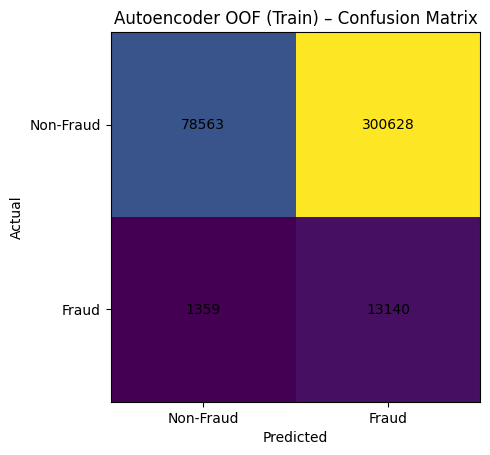

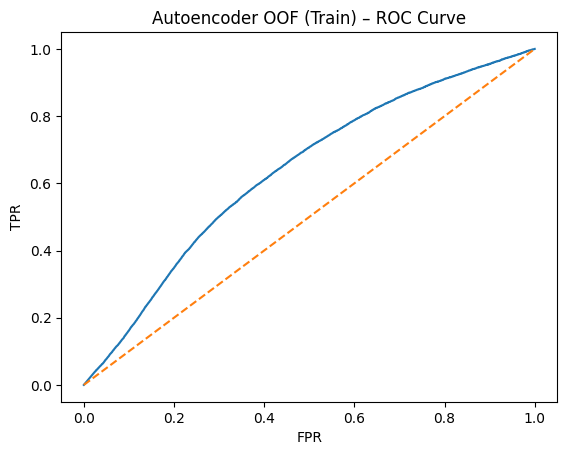

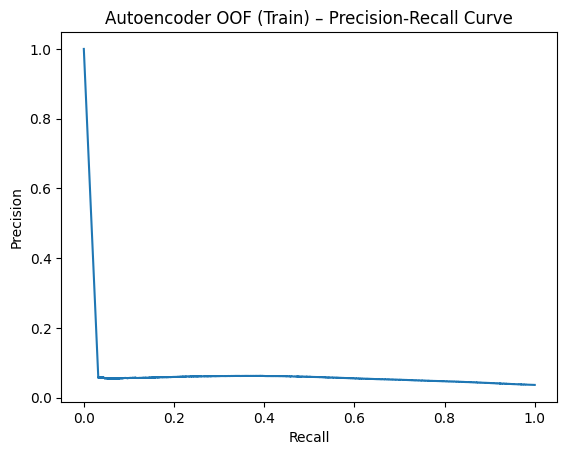

OOF coverage: 0.8333262776441901 (fraction of train rows used for meta)


In [8]:
# -----------------------------
# Generate OOF risk scores with best hyperparams (TimeSeriesSplit)
# -----------------------------
tss = TimeSeriesSplit(n_splits=N_SPLITS_OOF)

oof_score = np.full(len(X_train_np), np.nan, dtype=float)
oof_fold = np.full(len(X_train_np), -1, dtype=int)
has_oof = np.zeros(len(X_train_np), dtype=bool)

for fold, (tr_idx, va_idx) in enumerate(tss.split(X_train_np), start=1):
    X_tr_np, X_va_np = X_train_np[tr_idx], X_train_np[va_idx]
    y_va = y_train.values[va_idx]

    model = AutoEncoder(
        input_dim=input_dim,
        hidden_dim=best_hparams["hidden_dim"],
        latent_dim=best_hparams["latent_dim"],
        n_layers=best_hparams["n_layers"],
        dropout=best_hparams["dropout"],
    )
    model, _ = train_ae(
        model,
        X_tr_np=X_tr_np,
        X_va_np=X_va_np,
        lr=best_hparams["lr"],
        weight_decay=best_hparams["weight_decay"],
        batch_size=best_hparams["batch_size"],
        max_epochs=best_hparams["max_epochs"],
        patience=PATIENCE,
    )

    tr_err = reconstruction_error(model, X_tr_np)
    va_err = reconstruction_error(model, X_va_np)

    err_lo, err_hi = fit_robust_minmax(tr_err, q_low=0.01, q_high=0.99)
    va_score = transform_robust_minmax(va_err, err_lo, err_hi)

    oof_score[va_idx] = va_score
    oof_fold[va_idx] = fold
    has_oof[va_idx] = True

    print(f"Fold {fold}/{N_SPLITS_OOF} F2={compute_f2(y_va, va_score):.4f}")

# Evaluate OOF only where we actually have OOF predictions
mask = has_oof
_ = evaluate_binary(y_train.values[mask], oof_score[mask], threshold=THRESHOLD, title="Autoencoder OOF (Train)")
print("OOF coverage:", mask.mean(), "(fraction of train rows used for meta)")



[Train reconstruction error] n=472432  nan%=0.0000
0.00     0.000505
0.01     0.001807
0.05     0.002674
0.50     0.009701
0.95     0.080590
0.99     0.166185
1.00    24.691715
  >=  0.001: 0.9998 (fraction predicted fraud at threshold)
  >=   0.01: 0.4889 (fraction predicted fraud at threshold)
  >=   0.05: 0.1027 (fraction predicted fraud at threshold)
  >=    0.1: 0.0333 (fraction predicted fraud at threshold)
  >=    0.2: 0.0066 (fraction predicted fraud at threshold)
  >=    0.5: 0.0007 (fraction predicted fraud at threshold)

[Test reconstruction error] n=118108  nan%=0.0000
0.00     0.001215
0.01     0.003634
0.05     0.005128
0.50     0.015886
0.95     0.137988
0.99     1.498583
1.00    32.604988
  >=  0.001: 1.0000 (fraction predicted fraud at threshold)
  >=   0.01: 0.7104 (fraction predicted fraud at threshold)
  >=   0.05: 0.1680 (fraction predicted fraud at threshold)
  >=    0.1: 0.0737 (fraction predicted fraud at threshold)
  >=    0.2: 0.0323 (fraction predicted fraud

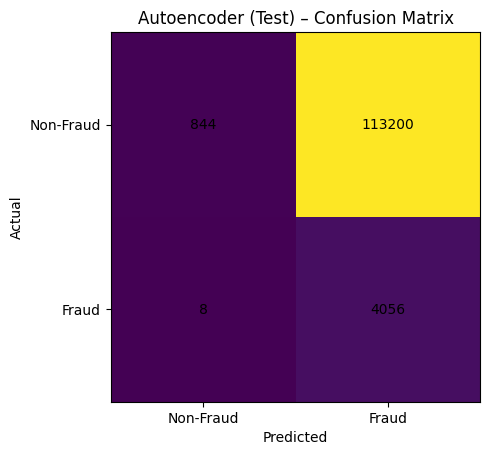

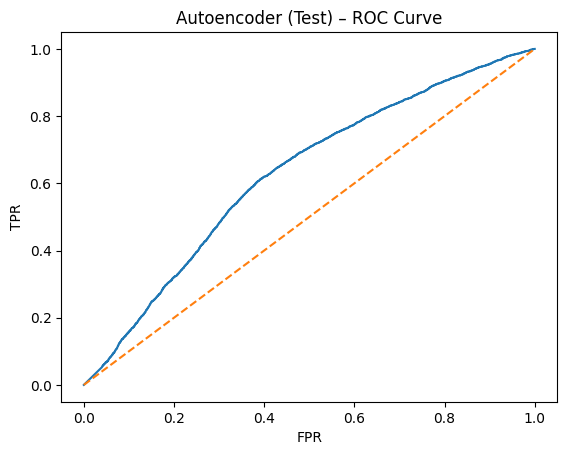

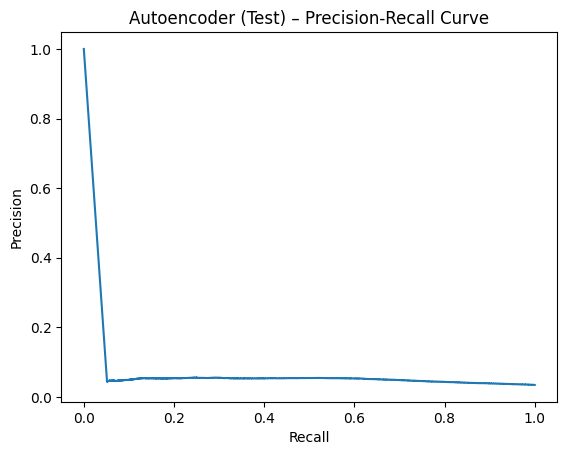

Saved: /content/drive/MyDrive/RThesis/oof_ae.csv
Saved: /content/drive/MyDrive/RThesis/test_ae.csv


In [14]:
# -----------------------------
# Fit final AE on FULL train (unsupervised), score test
# -----------------------------
# Use last 10% of train as internal validation for early stopping (time-aware)
split = int(len(X_train_np) * 0.90)
X_tr_np, X_va_np = X_train_np[:split], X_train_np[split:]

final_model = AutoEncoder(
    input_dim=input_dim,
    hidden_dim=best_hparams["hidden_dim"],
    latent_dim=best_hparams["latent_dim"],
    n_layers=best_hparams["n_layers"],
    dropout=best_hparams["dropout"],
)
final_model, _ = train_ae(
    final_model,
    X_tr_np=X_tr_np,
    X_va_np=X_va_np,
    lr=best_hparams["lr"],
    weight_decay=best_hparams["weight_decay"],
    batch_size=best_hparams["batch_size"],
    max_epochs=best_hparams["max_epochs"],
    patience=PATIENCE,
)

train_err_full = reconstruction_error(final_model, X_train_np)
test_err = reconstruction_error(final_model, X_test_np)

# Robust scale based on FULL train errors (avoid outlier compression)
err_lo_full, err_hi_full = fit_robust_minmax(train_err_full, q_low=0.01, q_high=0.99)
test_score = transform_robust_minmax(test_err, err_lo_full, err_hi_full)

# Diagnostics (helps detect the 'all non-fraud' issue quickly)
describe_scores(train_err_full, "Train reconstruction error")
describe_scores(test_err, "Test reconstruction error")
describe_scores(test_score, "Test AE risk score")
print("Predicted fraud fraction @ THRESHOLD:", float(np.mean(test_score >= THRESHOLD)))

_ = evaluate_binary(y_test.values, test_score, threshold=THRESHOLD, title="Autoencoder (Test)")

# Save outputs
oof_df = pd.DataFrame({
    "row_id": row_id_train,
    "y_true": y_train.values,
    "has_oof": has_oof,
    "fold": oof_fold,
    "ae_score": oof_score,
    "pred_label": np.where(has_oof, (oof_score >= THRESHOLD).astype(int), np.nan),
    "threshold_used": np.where(has_oof, THRESHOLD, np.nan),
})
test_df = pd.DataFrame({
    "row_id": row_id_test,
    "y_true": y_test.values,
    "ae_score": test_score,
    "pred_label": (test_score >= THRESHOLD).astype(int),
    "threshold_used": THRESHOLD,
})

oof_path  = os.path.join(datapath, "oof_ae.csv")
test_path = os.path.join(datapath, "test_ae.csv")
oof_df.to_csv(oof_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved:", oof_path)
print("Saved:", test_path)


[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   4%|▍         | 9/200 [00:00<?, ?it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   6%|▌         | 11/200 [00:10<00:41,  4.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   6%|▌         | 12/200 [00:11<01:18,  2.41it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   6%|▋         | 13/200 [00:12<01:36,  1.93it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   7%|▋         | 14/200 [00:12<01:48,  1.72it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   8%|▊         | 15/200 [00:13<01:54,  1.62it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   8%|▊         | 16/200 [00:14<01:55,  1.59it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   8%|▊         | 17/200 [00:14<01:56,  1.57it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:   9%|▉         | 18/200 [00:15<01:57,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  10%|▉         | 19/200 [00:15<01:44,  1.74it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  10%|█         | 20/200 [00:16<01:49,  1.65it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  10%|█         | 21/200 [00:17<01:50,  1.62it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  11%|█         | 22/200 [00:17<01:52,  1.59it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  12%|█▏        | 23/200 [00:18<02:14,  1.31it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  12%|█▏        | 24/200 [00:19<02:32,  1.16it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  12%|█▎        | 25/200 [00:20<02:35,  1.12it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  13%|█▎        | 26/200 [00:21<02:25,  1.19it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  14%|█▎        | 27/200 [00:22<02:15,  1.28it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  14%|█▍        | 28/200 [00:22<02:10,  1.32it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  14%|█▍        | 29/200 [00:23<02:03,  1.39it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  15%|█▌        | 30/200 [00:24<01:58,  1.43it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  16%|█▌        | 31/200 [00:24<01:46,  1.59it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  16%|█▌        | 32/200 [00:25<01:50,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  16%|█▋        | 33/200 [00:26<01:50,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  17%|█▋        | 34/200 [00:26<01:49,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  18%|█▊        | 35/200 [00:27<01:49,  1.51it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  18%|█▊        | 36/200 [00:28<01:47,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  18%|█▊        | 37/200 [00:28<01:46,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  19%|█▉        | 38/200 [00:29<01:35,  1.70it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  20%|█▉        | 39/200 [00:30<01:49,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  20%|██        | 40/200 [00:30<01:36,  1.67it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  20%|██        | 41/200 [00:31<01:57,  1.36it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  21%|██        | 42/200 [00:32<01:54,  1.38it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  22%|██▏       | 43/200 [00:33<02:05,  1.25it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  22%|██▏       | 44/200 [00:34<02:14,  1.16it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  22%|██▎       | 45/200 [00:34<02:02,  1.27it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  23%|██▎       | 46/200 [00:35<01:57,  1.31it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  24%|██▎       | 47/200 [00:36<01:54,  1.34it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  24%|██▍       | 48/200 [00:36<01:47,  1.41it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  24%|██▍       | 49/200 [00:37<01:45,  1.43it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  25%|██▌       | 50/200 [00:38<01:43,  1.45it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  26%|██▌       | 51/200 [00:38<01:32,  1.61it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  26%|██▌       | 52/200 [00:39<01:33,  1.58it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  26%|██▋       | 53/200 [00:40<01:35,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  27%|██▋       | 54/200 [00:40<01:34,  1.54it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  28%|██▊       | 55/200 [00:41<01:33,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  28%|██▊       | 56/200 [00:41<01:23,  1.73it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  28%|██▊       | 57/200 [00:42<01:26,  1.65it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  29%|██▉       | 58/200 [00:43<01:29,  1.58it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  30%|██▉       | 59/200 [00:43<01:29,  1.57it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  30%|███       | 60/200 [00:44<01:40,  1.40it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  30%|███       | 61/200 [00:45<01:51,  1.24it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  31%|███       | 62/200 [00:46<01:57,  1.18it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  32%|███▏      | 63/200 [00:47<01:49,  1.25it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  32%|███▏      | 64/200 [00:47<01:44,  1.30it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  32%|███▎      | 65/200 [00:48<01:42,  1.32it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  33%|███▎      | 66/200 [00:49<01:36,  1.39it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  34%|███▎      | 67/200 [00:50<01:33,  1.42it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  34%|███▍      | 68/200 [00:50<01:24,  1.57it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  34%|███▍      | 69/200 [00:51<01:23,  1.56it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  35%|███▌      | 70/200 [00:51<01:27,  1.49it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  36%|███▌      | 71/200 [00:52<01:24,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  36%|███▌      | 72/200 [00:53<01:24,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  36%|███▋      | 73/200 [00:53<01:23,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  37%|███▋      | 74/200 [00:54<01:25,  1.48it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  38%|███▊      | 75/200 [00:55<01:17,  1.61it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  38%|███▊      | 76/200 [00:55<01:25,  1.44it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  38%|███▊      | 77/200 [00:56<01:17,  1.58it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  39%|███▉      | 78/200 [00:57<01:20,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  40%|███▉      | 79/200 [00:58<01:29,  1.36it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  40%|████      | 80/200 [00:58<01:35,  1.26it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  40%|████      | 81/200 [00:59<01:42,  1.16it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  41%|████      | 82/200 [01:00<01:42,  1.15it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  42%|████▏     | 83/200 [01:01<01:25,  1.36it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  42%|████▏     | 84/200 [01:02<01:31,  1.27it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  42%|████▎     | 85/200 [01:02<01:25,  1.35it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  43%|████▎     | 86/200 [01:03<01:14,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  44%|████▎     | 87/200 [01:03<01:14,  1.51it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  44%|████▍     | 88/200 [01:04<01:14,  1.51it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  44%|████▍     | 89/200 [01:05<01:15,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  45%|████▌     | 90/200 [01:06<01:14,  1.48it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  46%|████▌     | 91/200 [01:06<01:14,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  46%|████▌     | 92/200 [01:07<01:13,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  46%|████▋     | 93/200 [01:07<01:04,  1.66it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  47%|████▋     | 94/200 [01:08<01:06,  1.60it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  48%|████▊     | 95/200 [01:09<01:06,  1.58it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  48%|████▊     | 96/200 [01:09<01:08,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  48%|████▊     | 97/200 [01:10<01:09,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  49%|████▉     | 98/200 [01:11<01:18,  1.30it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  50%|████▉     | 99/200 [01:12<01:18,  1.29it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  50%|█████     | 100/200 [01:13<01:24,  1.19it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  50%|█████     | 101/200 [01:14<01:23,  1.18it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  51%|█████     | 102/200 [01:14<01:20,  1.22it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  52%|█████▏    | 103/200 [01:15<01:16,  1.27it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  52%|█████▏    | 104/200 [01:16<01:11,  1.34it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  52%|█████▎    | 105/200 [01:17<01:09,  1.36it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  53%|█████▎    | 106/200 [01:17<01:07,  1.39it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  54%|█████▎    | 107/200 [01:18<01:05,  1.42it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  54%|█████▍    | 108/200 [01:19<01:03,  1.44it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  55%|█████▍    | 109/200 [01:19<00:56,  1.61it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  55%|█████▌    | 110/200 [01:20<01:03,  1.42it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  56%|█████▌    | 111/200 [01:20<00:56,  1.56it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  56%|█████▌    | 112/200 [01:21<00:56,  1.56it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  56%|█████▋    | 113/200 [01:22<00:55,  1.56it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  57%|█████▋    | 114/200 [01:22<00:56,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  57%|█████▊    | 115/200 [01:23<00:55,  1.53it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  58%|█████▊    | 116/200 [01:24<00:57,  1.45it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  58%|█████▊    | 117/200 [01:25<00:58,  1.42it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  59%|█████▉    | 118/200 [01:26<01:06,  1.23it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  60%|█████▉    | 119/200 [01:27<01:10,  1.15it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  60%|██████    | 120/200 [01:28<01:10,  1.14it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  60%|██████    | 121/200 [01:28<01:04,  1.23it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  61%|██████    | 122/200 [01:29<00:59,  1.31it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  62%|██████▏   | 123/200 [01:29<00:50,  1.53it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  62%|██████▏   | 124/200 [01:30<00:49,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  62%|██████▎   | 125/200 [01:30<00:48,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  63%|██████▎   | 126/200 [01:31<00:47,  1.54it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  64%|██████▎   | 127/200 [01:32<00:48,  1.51it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  64%|██████▍   | 128/200 [01:33<00:47,  1.51it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  64%|██████▍   | 129/200 [01:33<00:42,  1.67it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  65%|██████▌   | 130/200 [01:34<00:42,  1.65it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  66%|██████▌   | 131/200 [01:34<00:42,  1.61it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  66%|██████▌   | 132/200 [01:35<00:43,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  66%|██████▋   | 133/200 [01:36<00:43,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  67%|██████▋   | 134/200 [01:36<00:43,  1.53it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  68%|██████▊   | 135/200 [01:37<00:47,  1.38it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  68%|██████▊   | 136/200 [01:38<00:51,  1.24it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  68%|██████▊   | 137/200 [01:39<00:48,  1.30it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  69%|██████▉   | 138/200 [01:40<00:52,  1.19it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  70%|██████▉   | 139/200 [01:41<00:49,  1.23it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  70%|███████   | 140/200 [01:41<00:45,  1.31it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  70%|███████   | 141/200 [01:42<00:44,  1.34it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  71%|███████   | 142/200 [01:43<00:41,  1.39it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  72%|███████▏  | 143/200 [01:43<00:39,  1.43it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  72%|███████▏  | 144/200 [01:44<00:38,  1.44it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  72%|███████▎  | 145/200 [01:44<00:34,  1.60it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  73%|███████▎  | 146/200 [01:45<00:35,  1.53it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  74%|███████▎  | 147/200 [01:46<00:34,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  74%|███████▍  | 148/200 [01:46<00:34,  1.52it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  74%|███████▍  | 149/200 [01:47<00:33,  1.50it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  75%|███████▌  | 150/200 [01:48<00:33,  1.48it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  76%|███████▌  | 151/200 [01:48<00:30,  1.60it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  76%|███████▌  | 152/200 [01:49<00:30,  1.58it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  76%|███████▋  | 153/200 [01:50<00:29,  1.57it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  77%|███████▋  | 154/200 [01:51<00:33,  1.39it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  78%|███████▊  | 155/200 [01:51<00:32,  1.39it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  78%|███████▊  | 156/200 [01:53<00:39,  1.10it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  78%|███████▊  | 157/200 [01:53<00:38,  1.12it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  79%|███████▉  | 158/200 [01:54<00:35,  1.20it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  80%|███████▉  | 159/200 [01:55<00:29,  1.40it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  80%|████████  | 160/200 [01:55<00:27,  1.44it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  80%|████████  | 161/200 [01:56<00:26,  1.45it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  81%|████████  | 162/200 [01:57<00:25,  1.49it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  82%|████████▏ | 163/200 [01:57<00:24,  1.50it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  82%|████████▏ | 164/200 [01:58<00:24,  1.49it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  82%|████████▎ | 165/200 [01:59<00:23,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  83%|████████▎ | 166/200 [01:59<00:23,  1.43it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  84%|████████▎ | 167/200 [02:00<00:22,  1.44it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  84%|████████▍ | 168/200 [02:00<00:19,  1.63it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  84%|████████▍ | 169/200 [02:01<00:19,  1.60it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  85%|████████▌ | 170/200 [02:02<00:18,  1.60it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  86%|████████▌ | 171/200 [02:02<00:18,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  86%|████████▌ | 172/200 [02:03<00:19,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  86%|████████▋ | 173/200 [02:04<00:18,  1.47it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  87%|████████▋ | 174/200 [02:05<00:19,  1.33it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  88%|████████▊ | 175/200 [02:06<00:20,  1.22it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  88%|████████▊ | 176/200 [02:06<00:18,  1.31it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  88%|████████▊ | 177/200 [02:07<00:17,  1.35it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  89%|████████▉ | 178/200 [02:08<00:15,  1.42it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  90%|████████▉ | 179/200 [02:08<00:14,  1.41it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  90%|█████████ | 180/200 [02:09<00:12,  1.58it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  90%|█████████ | 181/200 [02:10<00:12,  1.57it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  91%|█████████ | 182/200 [02:10<00:11,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  92%|█████████▏| 183/200 [02:11<00:11,  1.54it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  92%|█████████▏| 184/200 [02:11<00:09,  1.70it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  92%|█████████▎| 185/200 [02:12<00:10,  1.45it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  93%|█████████▎| 186/200 [02:13<00:09,  1.45it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  94%|█████████▎| 187/200 [02:13<00:07,  1.65it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  94%|█████████▍| 188/200 [02:14<00:08,  1.41it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  94%|█████████▍| 189/200 [02:15<00:07,  1.55it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  95%|█████████▌| 190/200 [02:15<00:06,  1.54it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  96%|█████████▌| 191/200 [02:16<00:05,  1.53it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  96%|█████████▌| 192/200 [02:17<00:05,  1.43it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  96%|█████████▋| 193/200 [02:18<00:04,  1.43it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  97%|█████████▋| 194/200 [02:19<00:04,  1.24it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  98%|█████████▊| 195/200 [02:20<00:04,  1.17it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  98%|█████████▊| 196/200 [02:20<00:03,  1.26it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  98%|█████████▊| 197/200 [02:21<00:02,  1.32it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer:  99%|█████████▉| 198/200 [02:22<00:01,  1.36it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer: 100%|█████████▉| 199/200 [02:22<00:00,  1.37it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer: 100%|██████████| 200/200 [02:23<00:00,  1.41it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.
[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite n

PermutationExplainer explainer: 201it [02:24,  1.33it/s]

[WARN] err_for_transform: replaced non-finite values (NaN/inf) with finite numbers.


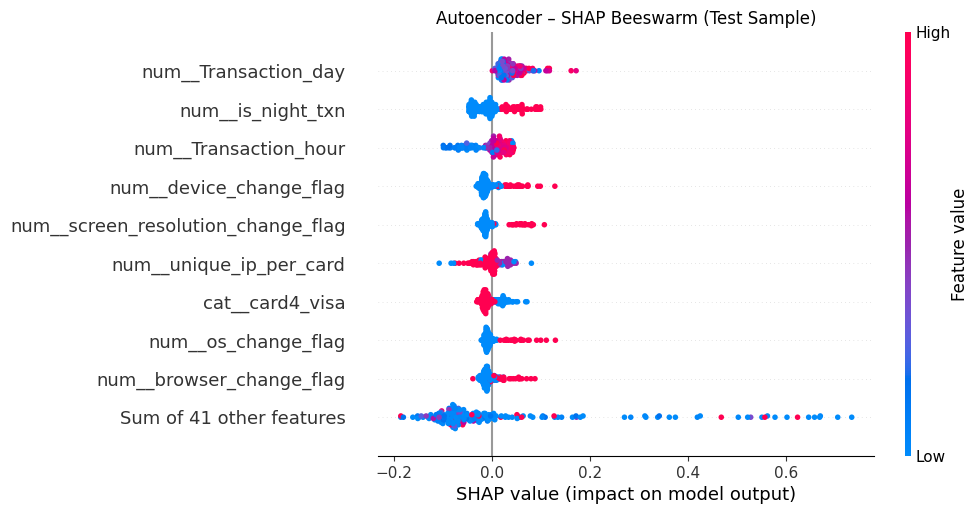

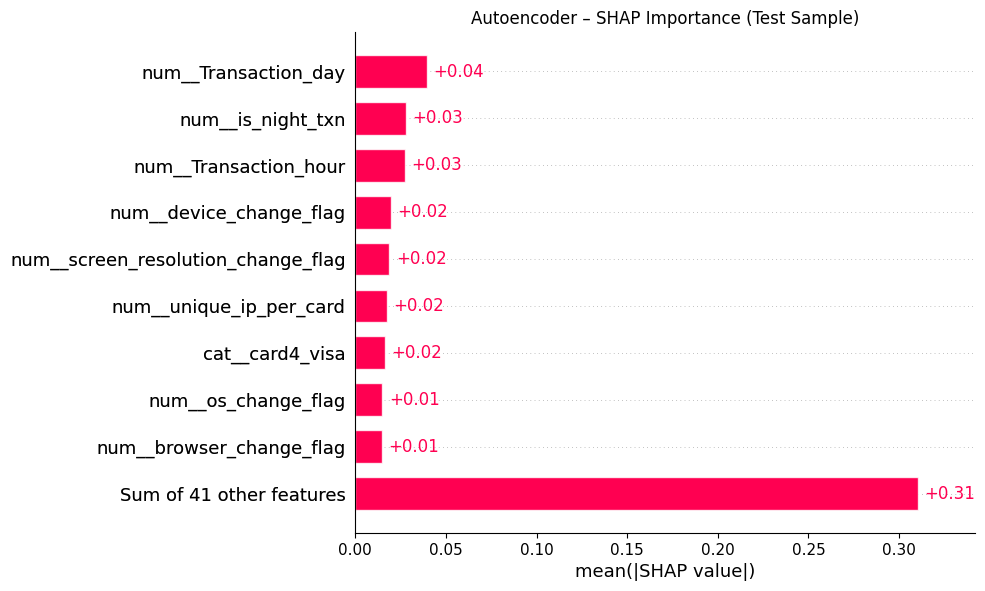

In [10]:
# -----------------------------
# SHAP – explain AE reconstruction-error risk score
# -----------------------------
import shap

# We'll explain the *scaled reconstruction error* as a function of the input features.
# For stability/speed, we use a small background and a small sample.
BG_SIZE = min(100, len(X_train_df))
SAMPLE_SIZE = min(200, len(X_test_df))

background = X_train_df.sample(n=BG_SIZE, random_state=SEED)
sample = X_test_df.sample(n=SAMPLE_SIZE, random_state=SEED)

def ae_score_fn(X_df: pd.DataFrame) -> np.ndarray:
    X_np = X_df.values.astype(np.float32)
    err = reconstruction_error(final_model, X_np)
    return transform_robust_minmax(err, err_lo_full, err_hi_full)

# shap.Explainer will choose a suitable method (often Permutation) for black-box models
masker = shap.maskers.Independent(background)
explainer = shap.Explainer(lambda X: ae_score_fn(pd.DataFrame(X, columns=X_train_df.columns)), masker)

# Limit evaluations for speed; increase max_evals for better estimates
shap_values = explainer(sample, max_evals=2000)

# Beeswarm plot
shap.plots.beeswarm(shap_values, show=False)
plt.title("Autoencoder – SHAP Beeswarm (Test Sample)")
plt.show()

# Global importance bar plot
shap.plots.bar(shap_values, show=False)
plt.title("Autoencoder – SHAP Importance (Test Sample)")
plt.show()


In [18]:
print("Fraud rate:", y_test.mean())

Fraud rate: 0.034409184813899145


In [19]:
print("NaN %:", np.mean(np.isnan(test_score))*100)
print("Min/Max:", np.min(test_score), np.max(test_score))
print("Quantiles:", np.quantile(test_score, [0.01,0.05,0.5,0.95,0.99]))

NaN %: 0.0
Min/Max: 0.0 1.0
Quantiles: [0.01111697 0.02020693 0.08565076 0.82846417 1.        ]
